<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Environment" data-toc-modified-id="Environment-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Environment</a></span></li></ul></li><li><span><a href="#Main" data-toc-modified-id="Main-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Main</a></span><ul class="toc-item"><li><span><a href="#Extract/Inspect-Data" data-toc-modified-id="Extract/Inspect-Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Extract/Inspect Data</a></span></li><li><span><a href="#Make-Plots" data-toc-modified-id="Make-Plots-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Make Plots</a></span></li></ul></li><li><span><a href="#Scratch" data-toc-modified-id="Scratch-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scratch</a></span></li></ul></div>

# Preamble

## Import

In [1]:
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import subprocess
import os

sns.set(context='poster')

## Functions

In [2]:
def measure(row,measurements=None,explode=None):
    if explode is None:
         measure = [ 
            {
                'num_people': row['num_people'],
                'mean_connections': row['mean_connections'],
                'size': row['size'],
                'max_memory': row['max_memory'],
                'runtime_total': row['runtime']['total'],
                'runtime_choose': row['runtime']['choose'],
                'runtime_available': row['runtime']['available'] # runtime_available
            } 
        ]
    if explode == 'runtime_choose': 
        measure = [ 
            {
                'num_people': row['num_people'],
                'mean_connections': row['mean_connections'],
                'size': row['size'],
                'max_memory': row['max_memory'],
                'runtime_total': row['runtime']['total'],
                'runtime_choose': runtime_choose,
                'runtime_available': row['runtime']['available'] # runtime_available
            } 
            # for runtime_available in row['runtime']['available'] 
            for runtime_choose in row['runtime']['choose']
        ]
    if explode == 'runtime_available':
        measure = [ 
            {
                'num_people': row['num_people'],
                'mean_connections': row['mean_connections'],
                'size': row['size'],
                'max_memory': row['max_memory'],
                'runtime_total': row['runtime']['total'],
                'runtime_choose': row['runtime']['choose'],
                'runtime_available': runtime_available
            } 
            for runtime_available in row['runtime']['available']
        ]
    
    measurements.append(measure)

In [3]:
def extract_data(path=None,explode=None):
    # Sync with S3 Results folder
    cmd = [
        'aws',
         's3',
         'sync',
         's3://infectionsim-experiment-data/connections/',
         'results',
         '--profile',
         'is',
         '--exact-timestamps'
    ]
    subprocess.run(cmd)
    
    
    # Load all the results files and then concat into one dataframe
    data = []
    for root, dirs, files in os.walk(path, topdown=False):
       for name in files:
            with open(os.path.join(path,name),'rb') as _file:
                datum = pkl.load(_file)

            # Load into data frame
            data.append(pd.DataFrame(datum))
    data = pd.concat(data)


    # Extract measurements
    measurements = []
    _ = data.apply(measure,
                   measurements=measurements,
                   explode=explode,
                   axis=1)

    measurements = list(itertools.chain(*measurements))

    data = pd.DataFrame(measurements)
    
    return data

In [4]:
def make_fig(figsize=None):
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    return fig, ax

In [5]:
def make_runtime_plot(path=None,runtime='runtime_total',figsize=(20,12)):
    if runtime == 'runtime_total':
        explode = None
    else:
        explode = runtime
        
    data = extract_data(path=path,explode=explode)
    fig, ax = make_fig(figsize=figsize)
    sns.barplot(x='num_people',
                y=runtime,
                hue='mean_connections',
                data=data,ax=ax)

In [6]:
def make_mem_plot(path=None):
    data = extract_data(path=path)
    data['max_memory'] = data['max_memory']/1024
    fig, ax = make_fig(figsize=(20,12))
    sns.barplot(x='num_people',
                y='max_memory',
                hue='mean_connections',
                data=data,
                ax=ax)
    ax.set(ylabel='Max Memory [MB]')

In [7]:
def make_size_plot(path=None):
    data = extract_data(path=path)
    fig, ax = make_fig(figsize=(20,12))
    data['size'] = data['size']/1024**2
    sns.barplot(x='num_people',
                y='size',
                hue='mean_connections',
                data=data,
                ax=ax)
    ax.set(ylabel='Connections Dataframe Size [MB]')

## Environment

In [8]:
path = 'results/'

# Main

## Extract/Inspect Data

In [9]:
%%time
data = extract_data(path=path)

CPU times: user 61.1 ms, sys: 26.8 ms, total: 87.9 ms
Wall time: 5.95 s


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [10]:
%%time
data.head()

CPU times: user 247 µs, sys: 42 µs, total: 289 µs
Wall time: 280 µs


,num_people,mean_connections,size,max_memory,runtime_total,runtime_choose,runtime_available
0,100,10.0,21136,72892,7.166681,"[0.03902029991149902, 0.02559661865234375, 0.0...","[0.0017733573913574219, 0.0012204647064208984,..."
1,100,10.0,18784,75252,6.876099,"[0.04063606262207031, 0.02249884605407715, 0.0...","[0.0015473365783691406, 0.0012137889862060547,..."
2,100,10.0,20736,75520,7.174305,"[0.03983354568481445, 0.08687639236450195, 0.0...","[0.0015597343444824219, 0.00115203857421875, 0..."
3,100,10.0,20040,72812,7.103747,"[0.018249034881591797, 0.09319353103637695, 0....","[0.0018181800842285156, 0.001211404800415039, ..."
4,100,10.0,19288,75240,6.901327,"[0.011188030242919922, 0.029139280319213867, 0...","[0.0015406608581542969, 0.0012426376342773438,..."


You can explode `runtime_choose` or `runtime_avilable`, but I would not explode both columns. That operation takes a long time.

In [11]:
%%time
data2 = extract_data(path=path,explode='runtime_choose')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



CPU times: user 15.1 s, sys: 678 ms, total: 15.7 s
Wall time: 20.6 s


In [12]:
data2.head()

,num_people,mean_connections,size,max_memory,runtime_total,runtime_choose,runtime_available
0,100,10.0,21136,72892,7.166681,0.039020,"[0.0017733573913574219, 0.0012204647064208984,..."
1,100,10.0,21136,72892,7.166681,0.025597,"[0.0017733573913574219, 0.0012204647064208984,..."
2,100,10.0,21136,72892,7.166681,0.013664,"[0.0017733573913574219, 0.0012204647064208984,..."
3,100,10.0,21136,72892,7.166681,0.031750,"[0.0017733573913574219, 0.0012204647064208984,..."
4,100,10.0,21136,72892,7.166681,0.026460,"[0.0017733573913574219, 0.0012204647064208984,..."


In [17]:
data.head()

,num_people,mean_connections,size,max_memory,runtime_total,runtime_choose,runtime_available
0,100,10.0,21136,72892,7.166681,"[0.03902029991149902, 0.02559661865234375, 0.0...","[0.0017733573913574219, 0.0012204647064208984,..."
1,100,10.0,18784,75252,6.876099,"[0.04063606262207031, 0.02249884605407715, 0.0...","[0.0015473365783691406, 0.0012137889862060547,..."
2,100,10.0,20736,75520,7.174305,"[0.03983354568481445, 0.08687639236450195, 0.0...","[0.0015597343444824219, 0.00115203857421875, 0..."
3,100,10.0,20040,72812,7.103747,"[0.018249034881591797, 0.09319353103637695, 0....","[0.0018181800842285156, 0.001211404800415039, ..."
4,100,10.0,19288,75240,6.901327,"[0.011188030242919922, 0.029139280319213867, 0...","[0.0015406608581542969, 0.0012426376342773438,..."


In [21]:
sns.set()

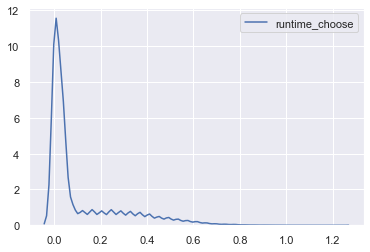

In [24]:
sns.kdeplot(data2.query(
    'num_people == 10000' and 'mean_connections == 10').runtime_choose)

## Make Plots

In [60]:
sns.set()
sns.set_context('poster')

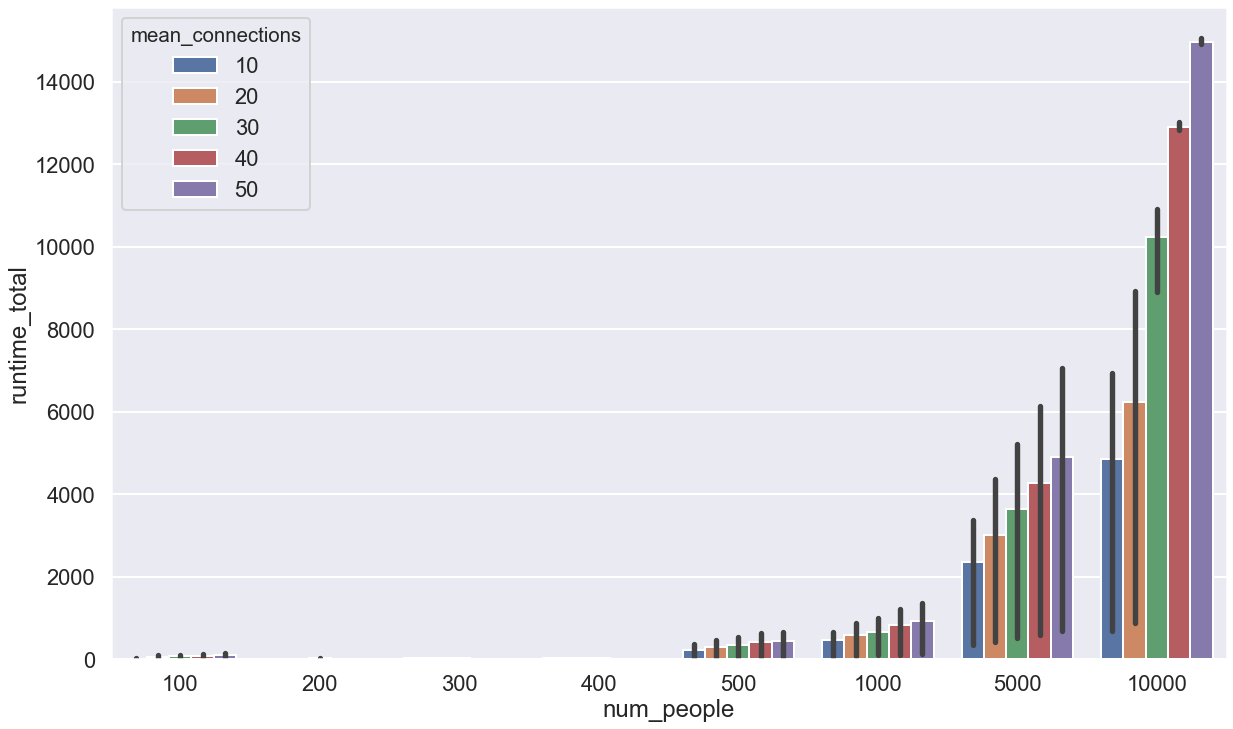

In [61]:
make_runtime_plot(path=path)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



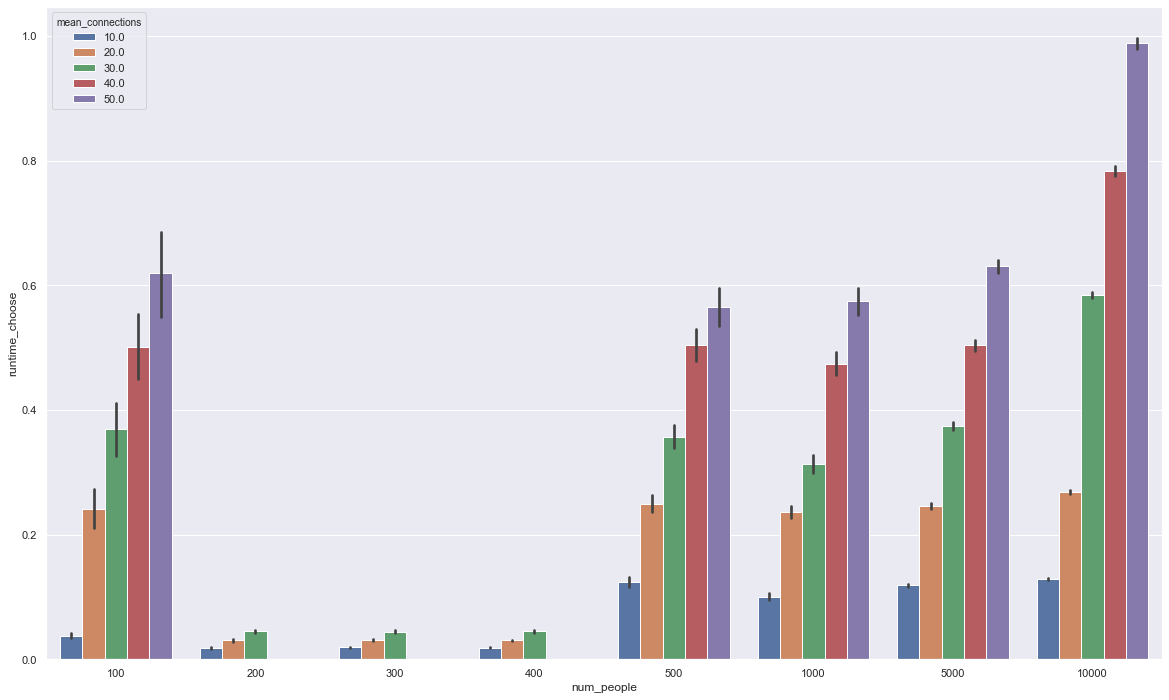

In [25]:
make_runtime_plot(path=path,runtime='runtime_choose')

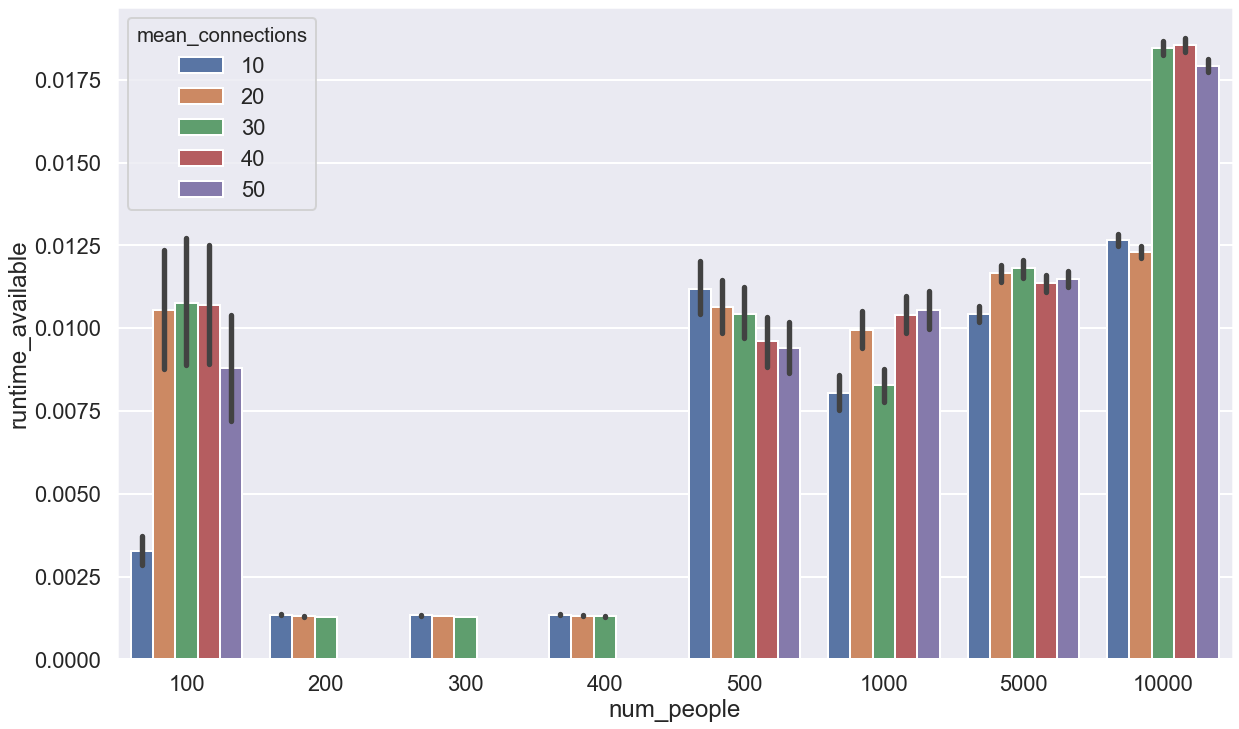

In [47]:
make_runtime_plot(path=path,runtime='runtime_available')

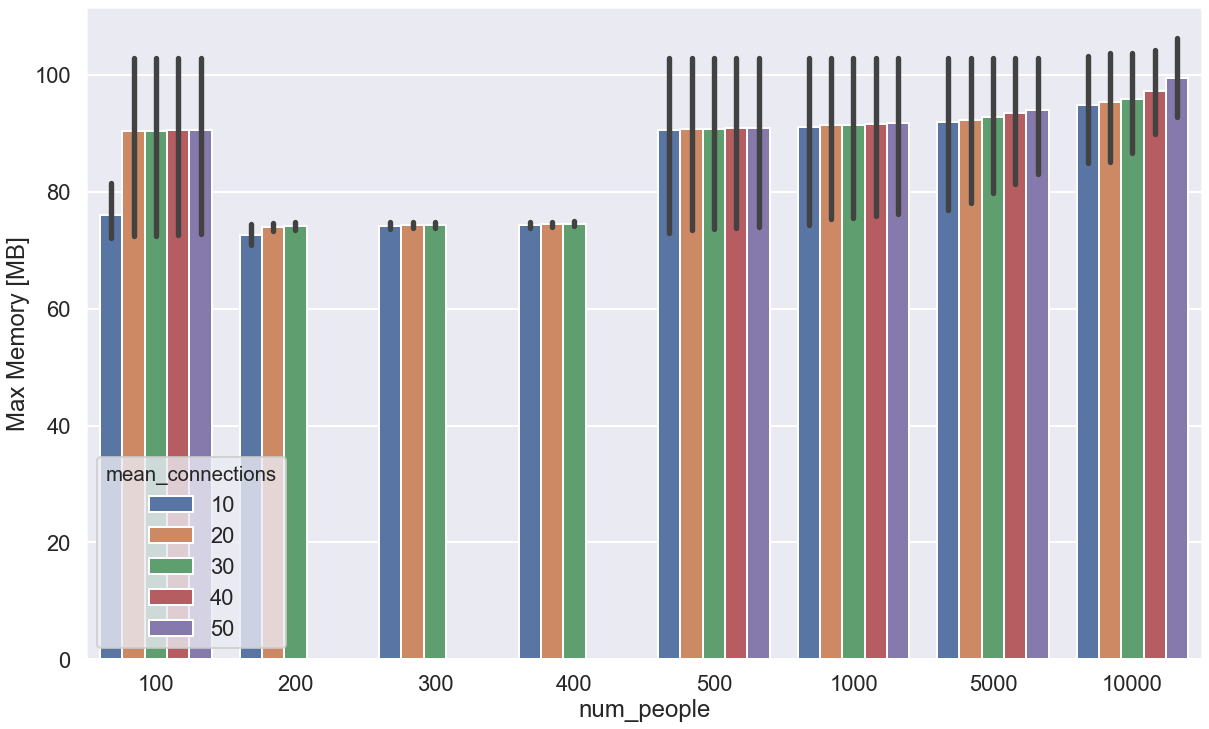

In [48]:
make_mem_plot(path=path)

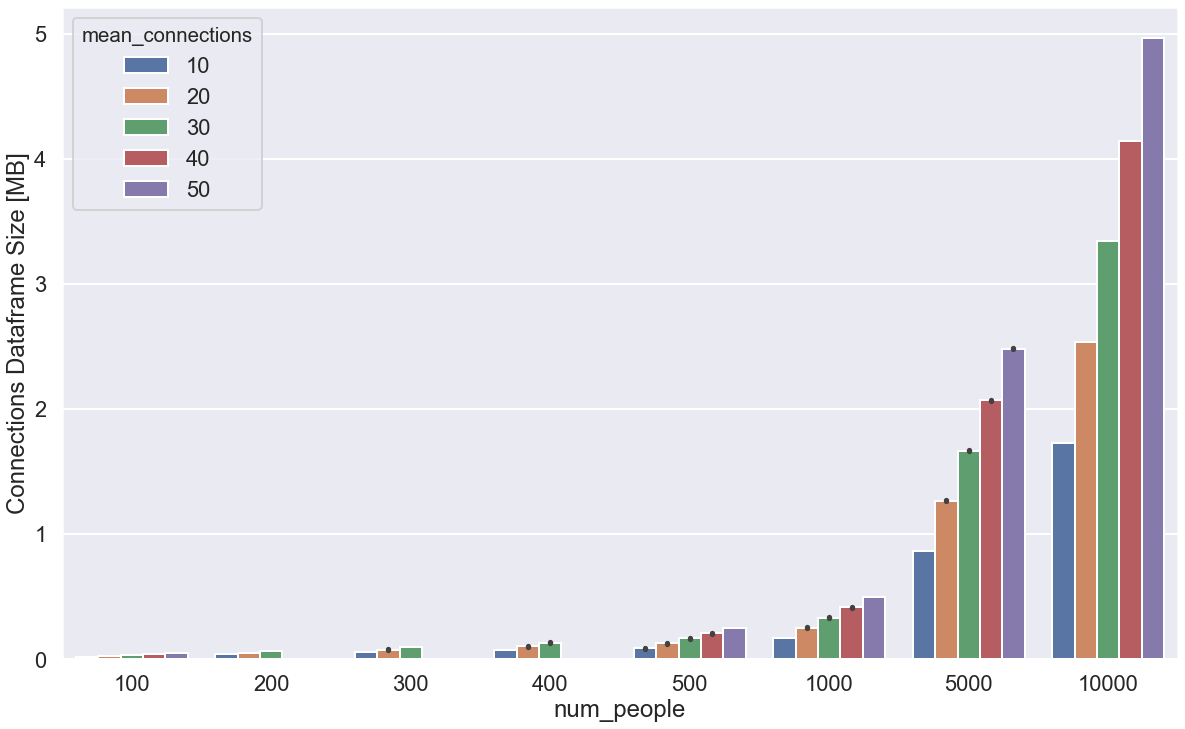

In [49]:
make_size_plot(path=path)

# Scratch

In [76]:
data = data.rename(columns={'size':'max_size'})

In [98]:
data['connection_density'] = data.mean_connections/data.num_people

In [102]:
data.columns

Index(['num_people', 'mean_connections', 'max_size', 'max_memory',
       'runtime_total', 'runtime_choose', 'runtime_available', 'scaled',
       'connection_density'],
      dtype='object')

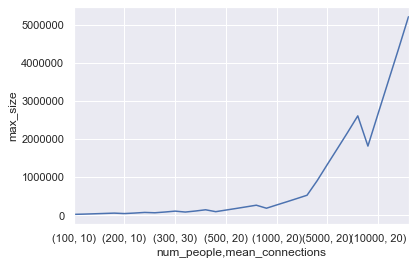

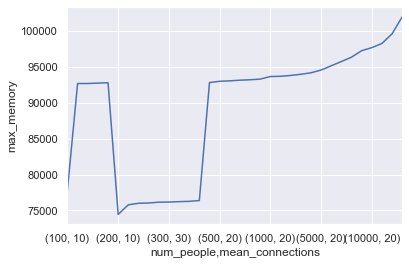

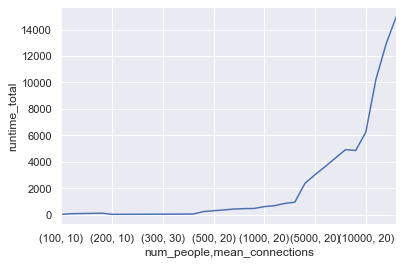

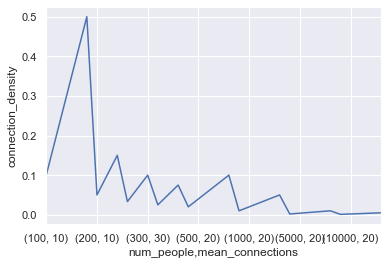

In [109]:
sns.set(context='notebook')
for col in ['max_size','max_memory','runtime_total','connection_density']:
    fig,ax = make_fig()
    data.groupby(['num_people','mean_connections'])[col].mean().plot(ax=ax)
    ax.set(ylabel=col)